# Deep Learning with PyTorch: A 60 Minute Blitz

Goal of this tutorial:
- Understand PyTorch’s Tensor library and neural networks at a high level.
- Train a small neural network to classify images.

## Part 4: Training a Classifier

### What about data?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a <b>torch.*Tensor</b>.
- For images, packages such as Pillow, OpenCV are useful.
- For audio, packages such as scipy and librosa.
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful.

Specifically for vision, we have created a package called <b>torchvision</b>, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., <b>torchvision.datasets</b> and <b>torch.utils.data.DataLoader</b>.

For this tutorial, we will use the <b>CIFAR10</b> dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size <b>3x32x32</b>, i.e. 3-channel color images of 32x32 pixels in size.

### Training an image classifier

We will do the following steps in order:
- Load and normalizing the CIFAR10 training and test datasets using <b>torchvision</b>.
- Define a convolutional neural network.
- Define a loss function.
- Train the network on the training data.
- Test the network on the test data.

### 1. Loading and Normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True, 
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False, 
                                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def imshow(img):
    img = img / 2 + 0.5 # unormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

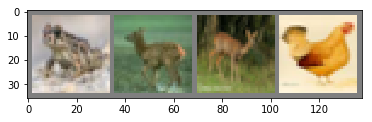

<generator object <genexpr> at 0x1198b2f68>


In [6]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s') % classes[labels[j]] for j in range(4))

### 2. Define a CNN

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 3. Define a Loss Function and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the Network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [13]:
epochs = 2

for epoch in range(epochs): # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %3f' %
                  (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.181620
[1,  4000] loss: 1.863679
[1,  6000] loss: 1.690363
[1,  8000] loss: 1.600194
[1, 10000] loss: 1.538575
[1, 12000] loss: 1.450677
[2,  2000] loss: 1.382904
[2,  4000] loss: 1.380292
[2,  6000] loss: 1.352401
[2,  8000] loss: 1.306526
[2, 10000] loss: 1.278514
[2, 12000] loss: 1.286837
Finished Training


Let’s quickly save our trained model:

In [18]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the Network on test data

First step. Let us display an image from the test set to get familiar.

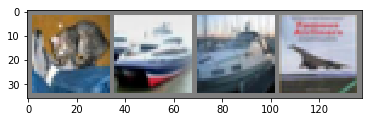

GroundTruth:    cat  ship  ship plane


In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [20]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [21]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [22]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car truck plane


Let us look at how the network performs on the whole dataset.

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' %
      (100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [29]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s: %3d %%' %
          (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane:  36 %
Accuracy of   car:  70 %
Accuracy of  bird:  36 %
Accuracy of   cat:  34 %
Accuracy of  deer:  41 %
Accuracy of   dog:  39 %
Accuracy of  frog:  73 %
Accuracy of horse:  76 %
Accuracy of  ship:  63 %
Accuracy of truck:  69 %


### 6. Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


The rest of this section assumes that <b>device</b> is a CUDA device.

In [32]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Remember that you will have to send the inputs and targets at every step to the GPU too:

In [33]:
inputs, labels = data[0].to(device), data[1].to(device)